# import & data load

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score,roc_curve,classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

import os
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

C:\Users\ZeusRyu\anaconda3\envs\kdt4\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
data_path = '../data/'
filelst = os.listdir(data_path)
df = pd.DataFrame()
for file in filelst:
    if '가뭄지수' in file:
        df = pd.concat([df,pd.read_csv(data_path+file, encoding='cp949')])
df

,지점,지점명,일시,SPI1,SPI2,SPI3,SPI4,SPI5,SPI6,SPI9,SPI12,SPI18,SPI24
0,105,강릉,1991-01-02,0.038,0.146,0.585,1.716,1.256,0.804,0.921,1.460,1.497,1.562
1,105,강릉,1991-01-03,0.016,0.122,0.588,1.756,1.263,0.838,0.923,1.462,1.434,1.533
2,105,강릉,1991-01-04,0.023,0.053,0.617,1.785,1.285,0.852,0.925,1.480,1.459,1.535
3,105,강릉,1991-01-05,0.032,0.065,0.634,1.903,1.332,0.861,0.930,1.482,1.469,1.494
4,105,강릉,1991-01-06,0.090,0.022,0.646,1.935,1.348,0.890,0.948,1.441,1.474,1.494
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3280,184,제주,2021-12-27,-0.120,-0.310,-0.470,0.770,1.220,0.540,0.380,0.510,0.170,0.150
3281,184,제주,2021-12-28,-0.100,-0.320,-0.440,0.820,1.240,0.560,0.370,0.470,0.190,0.150
3282,184,제주,2021-12-29,-0.080,-0.320,-0.420,0.920,1.240,0.590,0.360,0.470,0.200,0.150
3283,184,제주,2021-12-30,-0.070,-0.330,-0.530,0.960,1.240,0.600,0.370,0.460,0.170,0.130


In [3]:
spi = df[df['지점명']=='서울'].drop(['지점명','지점'],axis=1)
#spi = df.drop(['지점명','지점'],axis=1).groupby('일시').mean()

In [4]:
dat = pd.DataFrame({'일시':np.arange(dt.datetime(1996,1,1),dt.datetime(2022,1,1),dt.timedelta(days=1))}).astype('str')
spi = pd.merge(dat,spi,how='left',on='일시')
spi = spi.interpolate()
spi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9497 entries, 0 to 9496
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   일시      9497 non-null   object 
 1   SPI1    9497 non-null   float64
 2   SPI2    9497 non-null   float64
 3   SPI3    9497 non-null   float64
 4   SPI4    9497 non-null   float64
 5   SPI5    9497 non-null   float64
 6   SPI6    9497 non-null   float64
 7   SPI9    9497 non-null   float64
 8   SPI12   9497 non-null   float64
 9   SPI18   9497 non-null   float64
 10  SPI24   9497 non-null   float64
dtypes: float64(10), object(1)
memory usage: 890.3+ KB


In [5]:
spi['target'] = np.where(spi['SPI3']<-1.5,1,0)

In [6]:
spi['mtag']=spi['target'].shift(-180)

In [7]:
filepath = '../data/preprocessed_data/'

In [8]:
df['지점명'].unique()

array(['강릉', '서울', '청주', '대전', '대구', '전주', '광주', '부산', '제주'], dtype=object)

In [9]:
dat_lst = os.listdir(filepath)
dat_lst

['preprocessed_고층기후데이터.csv',
 'preprocessed_주변국 기상데이터_199601to202108.csv',
 'preprocessed_주변국 기상데이터_중국 부분 제거.csv',
 '국내_바다.csv',
 '국내기후(백령도제외).csv']

# reset Data

In [184]:
climate_kor = pd.read_csv(filepath+dat_lst[4],index_col=0)
climate_kor.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93504 entries, 0 to 11687
Data columns (total 33 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   시간           93504 non-null  object 
 1   관측지점         93504 non-null  object 
 2   평균 기온        93504 non-null  float64
 3   최저 기온        93504 non-null  float64
 4   최고 기온        93504 non-null  float64
 5   1시간 최다강수량    93504 non-null  float64
 6   일강수량         93504 non-null  float64
 7   최대 순간풍속      93504 non-null  float64
 8   최대 순간 풍속 풍향  93504 non-null  float64
 9   최대 풍속        93504 non-null  float64
 10  최대 풍속 풍향     93504 non-null  float64
 11  평균 풍속        93504 non-null  float64
 12  풍정합          93504 non-null  float64
 13  최대 풍향        93504 non-null  float64
 14  평균 이슬점온도     93504 non-null  float64
 15  평균 상대습도      93504 non-null  float64
 16  평균 증기압       93504 non-null  float64
 17  평균 현지기압      93504 non-null  float64
 18  최고 해면 기압     93504 non-null  float64
 19  최저 해

In [199]:
# 서울 데이터만 활용
cli_seoul = pd.merge(dat,climate_kor[climate_kor['관측지점'] == '서울'].drop('관측지점',axis=1).rename({'시간':'일시'},axis=1),how='left',on='일시')

In [200]:
# 고도 데이터 합치기
climate_high = pd.read_csv(filepath+dat_lst[0])
climate_high = pd.merge(dat,climate_high,how='left',on='일시')
cli_seoul = pd.concat([cli_seoul,climate_high.drop('일시',axis=1)], axis=1)
climate_high

,일시,50hPa_고도,50hPa_기온,50hPa_이슬점,50hPa_풍향,50hPa_풍속,70hPa_고도,70hPa_기온,70hPa_이슬점,70hPa_풍향,...,925hPa_고도,925hPa_기온,925hPa_이슬점,925hPa_풍향,925hPa_풍속,1000hPa_고도,1000hPa_기온,1000hPa_이슬점,1000hPa_풍향,1000hPa_풍속
0,1996-01-01,20385.00,-59.300,-67.800,268.750,43.625,18290.00,-61.150,-69.40,266.250,...,798.75,-5.600,-13.300,307.50,13.75,185.50,-3.850,-15.850,297.50,6.75
1,1996-01-02,20392.50,-54.850,-64.850,265.625,33.625,18257.50,-59.650,-68.15,257.500,...,757.75,-1.225,-4.175,246.25,18.25,132.00,1.875,-3.400,221.25,9.75
2,1996-01-03,20396.25,-54.000,-63.625,262.500,39.625,18231.25,-54.250,-63.50,266.250,...,790.00,-12.750,-18.725,303.75,24.25,191.75,-8.150,-17.400,308.75,14.75
3,1996-01-04,20465.00,-52.450,-62.450,279.375,19.750,18316.25,-55.075,-63.70,272.500,...,809.75,-8.700,-11.200,271.25,12.25,201.75,-5.600,-14.100,207.50,5.75
4,1996-01-05,20492.50,-51.450,-64.950,197.500,17.750,18332.50,-55.150,-67.15,242.500,...,791.00,2.500,1.975,237.50,12.25,161.50,0.575,-2.675,196.25,6.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9492,2021-12-27,20457.50,-58.450,-89.200,270.000,37.000,18337.50,-56.250,-87.75,266.250,...,852.00,-7.500,-10.850,293.75,26.00,243.75,-6.150,-11.050,220.00,3.50
9493,2021-12-28,20442.50,-59.350,-89.850,277.500,48.250,18325.00,-57.750,-88.50,278.750,...,837.00,-3.050,-6.200,257.50,17.00,215.25,-0.850,-4.725,161.25,6.00
9494,2021-12-29,20485.00,-58.025,-89.025,241.875,30.625,18333.75,-58.000,-89.00,265.000,...,789.25,-3.450,-6.825,272.50,25.00,167.00,0.825,-4.800,266.25,14.75
9495,2021-12-30,20480.00,-59.625,-89.875,228.125,32.125,18332.50,-54.725,-86.35,273.125,...,821.25,-9.900,-17.550,312.50,21.25,213.75,-4.550,-14.550,307.50,14.00


In [201]:
cli_seoul.drop('일시',axis=1,inplace=True)

In [202]:
# 
days=7
cli_window = cli_seoul
for i in range(1,days+1):
    tmp = cli_seoul.shift(i)
    tmp.columns += str(i)
    cli_window = pd.concat([cli_window,tmp],axis=1)
cli_window

,평균 기온,최저 기온,최고 기온,1시간 최다강수량,일강수량,최대 순간풍속,최대 순간 풍속 풍향,최대 풍속,최대 풍속 풍향,평균 풍속,...,925hPa_고도7,925hPa_기온7,925hPa_이슬점7,925hPa_풍향7,925hPa_풍속7,1000hPa_고도7,1000hPa_기온7,1000hPa_이슬점7,1000hPa_풍향7,1000hPa_풍속7
0,-3.2,-7.9,2.5,0.0,0.0,6.0,340.0,3.5,290.0,1.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.2,-3.9,3.9,0.0,0.0,9.3,230.0,3.8,230.0,1.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-4.5,-8.5,5.5,0.0,0.0,17.5,270.0,8.2,290.0,5.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-5.4,-10.7,-0.1,0.0,0.0,7.1,270.0,3.5,270.0,1.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.1,-2.1,2.0,0.0,2.0,7.8,70.0,3.7,70.0,2.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9492,-7.6,-12.9,-3.9,0.0,0.0,5.5,340.0,3.1,20.0,1.7,...,780.25,3.250,0.875,251.25,23.00,141.50,7.300,3.40,215.00,10.25
9493,-4.1,-8.5,-0.9,0.0,0.0,4.9,50.0,3.1,50.0,2.2,...,787.00,2.250,-8.125,310.00,13.25,154.50,5.000,-3.10,283.75,10.00
9494,0.4,-3.8,5.9,0.0,0.2,10.8,270.0,5.9,270.0,2.6,...,818.75,1.700,-19.050,336.25,9.25,190.75,2.075,-7.05,226.25,4.25
9495,-3.9,-6.8,0.2,0.0,0.0,12.3,320.0,6.6,290.0,3.3,...,830.75,0.050,-10.200,196.25,5.25,201.50,4.100,-6.40,200.00,3.50


In [204]:
cli_window = pd.concat([cli_window,spi['target']],axis=1)
cli_window['mtag'] = cli_window['target'].shift(-15)
cli_window

,평균 기온,최저 기온,최고 기온,1시간 최다강수량,일강수량,최대 순간풍속,최대 순간 풍속 풍향,최대 풍속,최대 풍속 풍향,평균 풍속,...,925hPa_이슬점7,925hPa_풍향7,925hPa_풍속7,1000hPa_고도7,1000hPa_기온7,1000hPa_이슬점7,1000hPa_풍향7,1000hPa_풍속7,target,mtag
0,-3.2,-7.9,2.5,0.0,0.0,6.0,340.0,3.5,290.0,1.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
1,0.2,-3.9,3.9,0.0,0.0,9.3,230.0,3.8,230.0,1.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
2,-4.5,-8.5,5.5,0.0,0.0,17.5,270.0,8.2,290.0,5.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
3,-5.4,-10.7,-0.1,0.0,0.0,7.1,270.0,3.5,270.0,1.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
4,-0.1,-2.1,2.0,0.0,2.0,7.8,70.0,3.7,70.0,2.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9492,-7.6,-12.9,-3.9,0.0,0.0,5.5,340.0,3.1,20.0,1.7,...,0.875,251.25,23.00,141.50,7.300,3.40,215.00,10.25,0,NaN
9493,-4.1,-8.5,-0.9,0.0,0.0,4.9,50.0,3.1,50.0,2.2,...,-8.125,310.00,13.25,154.50,5.000,-3.10,283.75,10.00,0,NaN
9494,0.4,-3.8,5.9,0.0,0.2,10.8,270.0,5.9,270.0,2.6,...,-19.050,336.25,9.25,190.75,2.075,-7.05,226.25,4.25,0,NaN
9495,-3.9,-6.8,0.2,0.0,0.0,12.3,320.0,6.6,290.0,3.3,...,-10.200,196.25,5.25,201.50,4.100,-6.40,200.00,3.50,0,NaN


In [210]:
# 일시 제거
test = cli_window.loc[8401:8765]
test

,평균 기온,최저 기온,최고 기온,1시간 최다강수량,일강수량,최대 순간풍속,최대 순간 풍속 풍향,최대 풍속,최대 풍속 풍향,평균 풍속,...,925hPa_이슬점7,925hPa_풍향7,925hPa_풍속7,1000hPa_고도7,1000hPa_기온7,1000hPa_이슬점7,1000hPa_풍향7,1000hPa_풍속7,target,mtag
8401,-5.0,-8.2,-0.6,0.0,0.0,8.6,290.0,4.3,270.0,2.1,...,-3.950,287.50,15.25,194.50,0.675,-7.125,190.00,7.25,0,0.0
8402,-4.9,-8.8,0.2,0.0,0.0,6.7,320.0,3.6,320.0,1.7,...,-23.700,341.25,15.50,210.50,-3.425,-15.925,312.50,12.75,0,0.0
8403,-3.5,-8.4,3.2,0.0,0.0,5.3,290.0,2.9,270.0,1.4,...,-26.525,313.75,23.50,240.50,-11.350,-22.850,311.25,13.75,0,0.0
8404,-1.1,-6.2,4.1,0.0,0.0,6.3,180.0,3.0,200.0,1.2,...,-24.475,322.50,21.00,260.50,-11.000,-21.750,318.75,11.50,0,0.0
8405,-2.8,-5.5,1.1,0.0,0.0,7.1,250.0,4.3,320.0,2.2,...,-21.275,311.25,22.25,281.25,-8.750,-20.000,311.25,15.00,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8761,-1.7,-4.6,2.6,0.0,0.0,7.7,290.0,4.3,290.0,2.1,...,-16.700,270.00,12.00,250.00,-2.900,-11.900,322.50,11.50,0,0.0
8762,1.1,-3.6,6.1,0.0,0.0,5.8,70.0,3.7,70.0,2.0,...,-5.500,297.50,14.50,237.00,0.550,-6.450,152.50,6.00,0,0.0
8763,3.8,1.1,6.2,0.0,1.4,6.6,110.0,4.4,70.0,2.9,...,-5.000,240.00,5.50,188.00,3.900,-3.100,180.00,7.00,0,0.0
8764,2.7,-5.7,6.8,0.0,0.4,13.1,320.0,7.4,320.0,2.9,...,-5.950,320.00,14.00,199.00,3.100,-1.500,307.50,13.00,0,0.0


In [213]:
train = pd.concat([cli_window.loc[:8400],cli_window.loc[8766:]])

In [16]:
cli_seoul = pd.concat([cli_seoul,spi['target']],axis=1)
cli_seoul['mtag'] = cli_seoul['target'].shift(-15)
cli_seoul

,평균 기온,최저 기온,최고 기온,1시간 최다강수량,일강수량,최대 순간풍속,최대 순간 풍속 풍향,최대 풍속,최대 풍속 풍향,평균 풍속,...,925hPa_이슬점,925hPa_풍향,925hPa_풍속,1000hPa_고도,1000hPa_기온,1000hPa_이슬점,1000hPa_풍향,1000hPa_풍속,target,mtag
0,-3.2,-7.9,2.5,0.0,0.0,6.0,340.0,3.5,290.0,1.6,...,-13.300,307.50,13.75,185.50,-3.850,-15.850,297.50,6.75,0,0.0
1,0.2,-3.9,3.9,0.0,0.0,9.3,230.0,3.8,230.0,1.8,...,-4.175,246.25,18.25,132.00,1.875,-3.400,221.25,9.75,0,0.0
2,-4.5,-8.5,5.5,0.0,0.0,17.5,270.0,8.2,290.0,5.3,...,-18.725,303.75,24.25,191.75,-8.150,-17.400,308.75,14.75,0,0.0
3,-5.4,-10.7,-0.1,0.0,0.0,7.1,270.0,3.5,270.0,1.2,...,-11.200,271.25,12.25,201.75,-5.600,-14.100,207.50,5.75,0,0.0
4,-0.1,-2.1,2.0,0.0,2.0,7.8,70.0,3.7,70.0,2.4,...,1.975,237.50,12.25,161.50,0.575,-2.675,196.25,6.50,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9492,-7.6,-12.9,-3.9,0.0,0.0,5.5,340.0,3.1,20.0,1.7,...,-10.850,293.75,26.00,243.75,-6.150,-11.050,220.00,3.50,0,NaN
9493,-4.1,-8.5,-0.9,0.0,0.0,4.9,50.0,3.1,50.0,2.2,...,-6.200,257.50,17.00,215.25,-0.850,-4.725,161.25,6.00,0,NaN
9494,0.4,-3.8,5.9,0.0,0.2,10.8,270.0,5.9,270.0,2.6,...,-6.825,272.50,25.00,167.00,0.825,-4.800,266.25,14.75,0,NaN
9495,-3.9,-6.8,0.2,0.0,0.0,12.3,320.0,6.6,290.0,3.3,...,-17.550,312.50,21.25,213.75,-4.550,-14.550,307.50,14.00,0,NaN


In [17]:
x = cli_seoul.dropna().drop(['mtag','target'],axis=1)
y = cli_seoul.dropna()['mtag']

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.2, stratify=y, random_state=111)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train, random_state=111)

[0]	validation_0-auc:0.63261	validation_1-auc:0.57479
[2]	validation_0-auc:0.81737	validation_1-auc:0.66834
[4]	validation_0-auc:0.89744	validation_1-auc:0.68868
[6]	validation_0-auc:0.94274	validation_1-auc:0.70694
[8]	validation_0-auc:0.95867	validation_1-auc:0.71269
[10]	validation_0-auc:0.97669	validation_1-auc:0.71991
[12]	validation_0-auc:0.98584	validation_1-auc:0.72071
[14]	validation_0-auc:0.98796	validation_1-auc:0.72607
[16]	validation_0-auc:0.99230	validation_1-auc:0.73784
[18]	validation_0-auc:0.99550	validation_1-auc:0.75315
[20]	validation_0-auc:0.99702	validation_1-auc:0.75262
[22]	validation_0-auc:0.99789	validation_1-auc:0.74969
[23]	validation_0-auc:0.99820	validation_1-auc:0.75169
auc: 0.7792237117322686
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96      1753
         1.0       0.40      0.04      0.08       144

    accuracy                           0.92      1897
   macro avg       0.66      0.52      0.52     

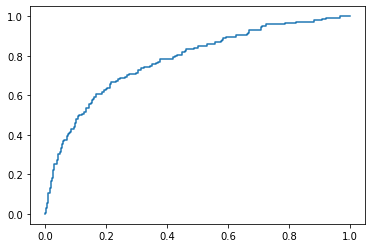

In [19]:
xgb = XGBClassifier(
#                     n_estimators=1000,
#                     max_depth = 9,
#                     learning_rate = 0.01,
#                     gamma = 1,
                   )
xgb.fit(x_train, y_train, 
        eval_metric='auc', 
        eval_set=[(x_train,y_train),(x_val,y_val)], 
        early_stopping_rounds=5,
        verbose=2)
pred = xgb.predict(x_test)
prob = xgb.predict_proba(x_test)

print('auc:',roc_auc_score(y_test, prob[:,1]))
print(classification_report(y_test,pred))
tpr, fpr, _ = roc_curve(y_test, prob[:,1])
plt.plot(tpr,fpr)


# window sliced data reset

In [59]:
x = cli_window.dropna().drop(['mtag','target'],axis=1)
y = cli_window.dropna()['mtag']

In [60]:
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.2, stratify=y, random_state=111)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train, random_state=111)

In [61]:
xgb = XGBClassifier(
#                     n_estimators=100,
#                     max_depth = 9,
#                     learning_rate = 0.01,
#                     gamma = 1.5,
                   )
xgb.fit(x_train, y_train, eval_metric='auc', eval_set=[(x_train,y_train),(x_val,y_val)], early_stopping_rounds=10,verbose=2)
pred = xgb.predict(x_test)
prob = xgb.predict_proba(x_test)

print('auc:',roc_auc_score(y_test, prob[:,1]))
print(classification_report(y_test,pred))

[0]	validation_0-auc:0.62603	validation_1-auc:0.55848
[2]	validation_0-auc:0.75789	validation_1-auc:0.60861
[4]	validation_0-auc:0.91202	validation_1-auc:0.68815
[6]	validation_0-auc:0.96349	validation_1-auc:0.70882
[8]	validation_0-auc:0.98009	validation_1-auc:0.74106
[10]	validation_0-auc:0.98955	validation_1-auc:0.74411
[12]	validation_0-auc:0.99535	validation_1-auc:0.75662
[14]	validation_0-auc:0.99817	validation_1-auc:0.75899
[16]	validation_0-auc:0.99891	validation_1-auc:0.75885
[18]	validation_0-auc:0.99956	validation_1-auc:0.75884
[20]	validation_0-auc:0.99970	validation_1-auc:0.77065
[22]	validation_0-auc:0.99995	validation_1-auc:0.76825
[24]	validation_0-auc:0.99998	validation_1-auc:0.77416
[26]	validation_0-auc:1.00000	validation_1-auc:0.78104
[28]	validation_0-auc:1.00000	validation_1-auc:0.78701
[30]	validation_0-auc:1.00000	validation_1-auc:0.78914
[32]	validation_0-auc:1.00000	validation_1-auc:0.79857
[34]	validation_0-auc:1.00000	validation_1-auc:0.80348
[36]	validation

70hPa_고도4      0.014174
250hPa_고도4     0.009129
70hPa_고도3      0.008238
250hPa_풍향6     0.008165
합계 대형증발량3      0.007922
                 ...   
안개 계속 시간4      0.000000
합계 3시간 신적설4    0.000000
일 최심적설4        0.000000
일 최심신적설4       0.000000
평균 기온4         0.000000
Length: 768, dtype: float32

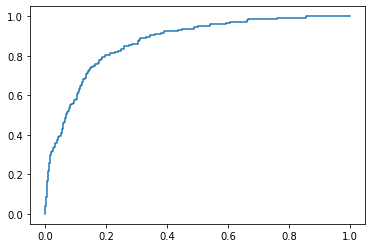

In [62]:
tpr, fpr, _ = roc_curve(y_test, prob[:,1])
plt.plot(tpr,fpr)
xgb.feature_importances_
x.columns
pd.Series( xgb.feature_importances_,x.columns).sort_values(ascending=False)

In [46]:
while True:
    ser = pd.Series(xgb.feature_importances_,x.columns).sort_values(ascending=False)
    if ser[ser==0].count() == 0:
        break
    col = list(ser[ser>0].index)
    col.append('mtag')
    x = cli_window[col].dropna().drop(['mtag'],axis=1)
    y = cli_window[col].dropna()['mtag']
    x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.2, stratify=y, random_state=111)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train, random_state=111)
    xgb = XGBClassifier()
    xgb.fit(x_train, y_train, eval_metric='auc', eval_set=[(x_train,y_train),(x_val,y_val)], early_stopping_rounds=10,verbose=0)
    pred = xgb.predict(x_test)
    prob = xgb.predict_proba(x_test)

    print('auc:',roc_auc_score(y_test, prob[:,1]))
    print(classification_report(y_test,pred))

auc: 0.8771892252046449
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96      1751
         1.0       0.70      0.05      0.09       144

    accuracy                           0.93      1895
   macro avg       0.81      0.52      0.53      1895
weighted avg       0.91      0.93      0.90      1895

auc: 0.8576448378704233
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96      1751
         1.0       0.69      0.06      0.11       144

    accuracy                           0.93      1895
   macro avg       0.81      0.53      0.54      1895
weighted avg       0.91      0.93      0.90      1895

auc: 0.8662787930706264
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96      1751
         1.0       0.78      0.05      0.09       144

    accuracy                           0.93      1895
   macro avg       0.85      0.52      0.53      1895
we

# smote

In [63]:
smote = SMOTE(random_state=11)
x_train_over, y_train_over = smote.fit_resample(x_train,y_train)
x_val_over, y_val_over = smote.fit_resample(x_train,y_train)

In [64]:
xgb = XGBClassifier()
xgb.fit(x_train_over, y_train_over, eval_metric='auc', eval_set=[(x_train_over,y_train_over),(x_val_over,y_val_over)], early_stopping_rounds=10,verbose=2)
pred = xgb.predict(x_test)
prob = xgb.predict_proba(x_test)

print('auc:',roc_auc_score(y_test, prob[:,1]))
print(classification_report(y_test,pred))

[0]	validation_0-auc:0.85534	validation_1-auc:0.85534
[2]	validation_0-auc:0.96664	validation_1-auc:0.96664
[4]	validation_0-auc:0.98574	validation_1-auc:0.98574
[6]	validation_0-auc:0.99198	validation_1-auc:0.99198
[8]	validation_0-auc:0.99476	validation_1-auc:0.99476
[10]	validation_0-auc:0.99657	validation_1-auc:0.99657
[12]	validation_0-auc:0.99768	validation_1-auc:0.99768
[14]	validation_0-auc:0.99866	validation_1-auc:0.99866
[16]	validation_0-auc:0.99913	validation_1-auc:0.99913
[18]	validation_0-auc:0.99939	validation_1-auc:0.99939
[20]	validation_0-auc:0.99959	validation_1-auc:0.99959
[22]	validation_0-auc:0.99971	validation_1-auc:0.99971
[24]	validation_0-auc:0.99984	validation_1-auc:0.99984
[26]	validation_0-auc:0.99988	validation_1-auc:0.99988
[28]	validation_0-auc:0.99995	validation_1-auc:0.99995
[30]	validation_0-auc:0.99997	validation_1-auc:0.99997
[32]	validation_0-auc:0.99998	validation_1-auc:0.99998
[34]	validation_0-auc:0.99999	validation_1-auc:0.99999
[36]	validation

최대 풍향6         0.034928
최대 풍속 풍향1      0.032639
최대 풍향2         0.019694
최대 풍향1         0.019204
합계 일조 시간2      0.018438
                 ...   
1시간 최다강수량6     0.000000
합계 3시간 신적설2    0.000000
일 최심신적설2       0.000000
일 최심적설4        0.000000
평균 기온4         0.000000
Length: 768, dtype: float32

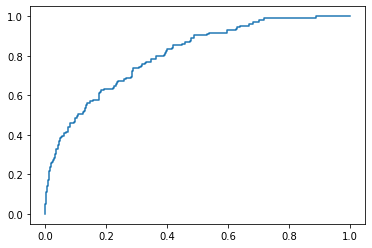

In [65]:
tpr, fpr, _ = roc_curve(y_test, prob[:,1])
plt.plot(tpr,fpr)
xgb.feature_importances_
x.columns
pd.Series(xgb.feature_importances_,x.columns).sort_values(ascending=False)

In [78]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
ada = AdaBoostClassifier()
ada.fit(x_train_over, y_train_over)
pred = ada.predict(x_test)
prob = ada.predict_proba(x_test)

print('auc:',roc_auc_score(y_test, prob[:,1]))
print(classification_report(y_test,pred))

auc: 0.6861376832286313
              precision    recall  f1-score   support

         0.0       0.94      0.86      0.90      1751
         1.0       0.17      0.33      0.22       144

    accuracy                           0.82      1895
   macro avg       0.55      0.60      0.56      1895
weighted avg       0.88      0.82      0.85      1895



# global climate

In [81]:
cli_all = pd.read_csv(filepath+dat_lst[1],index_col=0)
cli_all

,도시명,일시,평균기온,최고기온,최저기온,습도,풍향,풍속,강수량,해면기압,이슬점 온도,군집
0,청진,1996-01-01,-5.528571,-0.1,-9.9,53.571429,330.0,0.571429,0.0,1018.685714,-13.657143,n2
1,청진,1996-01-02,-3.825000,1.3,-8.2,72.875000,80.0,0.500000,0.0,1014.037500,-8.025000,n2
2,청진,1996-01-03,-6.912500,-1.4,-11.7,48.375000,330.0,3.000000,0.0,1010.537500,-16.100000,n2
3,청진,1996-01-04,-9.475000,-3.4,-19.2,56.500000,320.0,0.250000,0.0,1020.800000,-16.625000,n2
4,청진,1996-01-05,-4.487500,0.5,-9.9,71.750000,290.0,0.375000,0.0,1021.800000,-8.837500,n2
...,...,...,...,...,...,...,...,...,...,...,...,...
9370,후쿠오카,2021-08-27,29.175000,32.8,25.6,70.495833,30.0,5.125000,0.0,1014.391667,23.162500,n5
9371,후쿠오카,2021-08-28,28.641667,32.3,25.1,72.362500,40.0,4.958333,0.0,1014.325000,23.000000,n5
9372,후쿠오카,2021-08-29,28.908333,32.4,25.5,72.687500,290.0,5.041667,0.0,1014.754167,23.375000,n5
9373,후쿠오카,2021-08-30,28.904167,32.5,25.8,75.795833,310.0,4.541667,0.0,1015.587500,24.112500,n5


In [115]:
cli_global = pd.DataFrame()
for city in ['베이징','상하이','블라디보스톡','도쿄','후쿠오카','삿포로','평양','선양']:
    tmp = cli_all.query(f'도시명 == "{city}"').drop(['도시명','일시','군집'],axis=1)
    tmp.columns = city+tmp.columns
    cli_global = pd.concat([cli_global,tmp],axis=1)
cli_global

,베이징평균기온,베이징최고기온,베이징최저기온,베이징습도,베이징풍향,베이징풍속,베이징강수량,베이징해면기압,베이징이슬점 온도,상하이평균기온,...,평양이슬점 온도,선양평균기온,선양최고기온,선양최저기온,선양습도,선양풍향,선양풍속,선양강수량,선양해면기압,선양이슬점 온도
0,2.233333,7.1,-0.5,40.2000,70.0,2.333333,0.000000,1014.666667,-10.933333,3.800000,...,-17.671429,-1.633333,-0.9,-2.7,64.8000,10.0,3.333333,0.0,1012.233333,-7.433333
1,-1.250000,4.3,-5.4,12.2750,320.0,2.276333,0.000000,1027.675000,-27.512500,8.625000,...,-4.425000,-6.462500,-2.2,-12.1,33.2250,340.0,5.875000,0.0,1020.775000,-20.975000
2,-3.987500,-0.8,-7.3,19.7000,20.0,3.750000,0.000000,1027.637500,-24.812500,4.462500,...,-18.087500,-13.400000,-9.5,-17.6,31.7500,270.0,2.250000,0.0,1026.112500,-27.325000
3,-4.187500,-0.4,-7.7,39.4500,10.0,1.500000,0.000000,1020.300000,-16.400000,9.087500,...,-17.412500,-5.787500,-0.5,-11.6,53.8750,350.0,4.250000,0.0,1019.675000,-13.850000
4,-0.612500,3.7,-3.5,57.2875,10.0,2.250000,0.000000,1025.100000,-8.737500,11.700000,...,-4.387500,-11.325000,-6.4,-15.8,58.7625,30.0,3.000000,0.0,1025.525000,-18.025000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9370,24.425000,29.7,18.4,59.5375,90.0,1.875000,0.000000,1011.337500,15.087500,29.037500,...,19.112500,23.400000,27.6,19.2,65.1500,50.0,3.000000,0.0,1008.862500,15.850000
9371,23.462500,27.4,20.9,66.5125,30.0,1.250000,-2.970496,1012.887500,16.462500,29.671429,...,18.975000,21.712500,26.9,16.7,68.2875,20.0,2.000000,0.0,1011.075000,14.812500
9372,24.012500,27.7,19.6,72.2625,60.0,1.500000,0.000000,1013.800000,18.437500,30.125000,...,19.962500,20.387500,27.5,13.3,66.7500,20.0,1.625000,0.0,1013.525000,12.475000
9373,24.962500,27.2,21.5,72.2125,290.0,1.000000,-2.970496,1015.412500,19.350000,30.500000,...,18.587500,22.112500,29.6,16.4,72.9875,310.0,1.500000,0.0,1016.100000,16.037500


In [116]:
climate_day = pd.concat([cli_seoul,cli_global],axis=1).dropna().drop('일시',axis=1)

In [117]:
days=7
climate_week = pd.DataFrame()
for i in range(0,days):
    tmp = climate_day.shift(i)
    tmp.columns += str(i)
    climate_week = pd.concat([climate_week,tmp],axis=1)
climate_week

,평균 기온0,최저 기온0,최고 기온0,1시간 최다강수량0,일강수량0,최대 순간풍속0,최대 순간 풍속 풍향0,최대 풍속0,최대 풍속 풍향0,평균 풍속0,...,평양이슬점 온도6,선양평균기온6,선양최고기온6,선양최저기온6,선양습도6,선양풍향6,선양풍속6,선양강수량6,선양해면기압6,선양이슬점 온도6
0,-3.2,-7.9,2.5,0.0,0.0,6.0,340.0,3.5,290.0,1.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.2,-3.9,3.9,0.0,0.0,9.3,230.0,3.8,230.0,1.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-4.5,-8.5,5.5,0.0,0.0,17.5,270.0,8.2,290.0,5.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-5.4,-10.7,-0.1,0.0,0.0,7.1,270.0,3.5,270.0,1.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.1,-2.1,2.0,0.0,2.0,7.8,70.0,3.7,70.0,2.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9370,22.4,20.4,25.5,0.7,0.9,4.9,250.0,3.2,250.0,1.3,...,21.2250,21.314286,27.7,17.8,90.285714,350.0,1.142857,-2.304352,1002.957143,19.428571
9371,23.6,19.7,28.2,0.0,0.0,7.3,270.0,3.9,270.0,1.8,...,19.6375,26.025000,30.1,22.6,69.175000,30.0,3.375000,0.000000,1004.087500,19.637500
9372,23.7,21.9,26.3,0.7,0.9,5.6,340.0,3.4,320.0,1.6,...,19.9750,24.487500,29.5,19.5,80.912500,360.0,2.125000,-2.304352,1003.612500,20.687500
9373,24.2,21.2,27.7,0.0,0.0,4.5,270.0,2.9,250.0,1.4,...,20.1750,21.700000,24.4,18.3,90.400000,330.0,1.375000,-2.304352,998.662500,20.012500


In [118]:
climate_week.columns.tolist()

['평균 기온0',
 '최저 기온0',
 '최고 기온0',
 '1시간 최다강수량0',
 '일강수량0',
 '최대 순간풍속0',
 '최대 순간 풍속 풍향0',
 '최대 풍속0',
 '최대 풍속 풍향0',
 '평균 풍속0',
 '풍정합0',
 '최대 풍향0',
 '평균 이슬점온도0',
 '평균 상대습도0',
 '평균 증기압0',
 '평균 현지기압0',
 '최고 해면 기압0',
 '최저 해면기압0',
 '평균 해면기압0',
 '합계 일조 시간0',
 '1시간 최다 일사량0',
 '합계 일사0',
 '일 최심신적설0',
 '일 최심적설0',
 '합계 3시간 신적설0',
 '평균 전운량0',
 '평균 중하층운량0',
 '평균 지면온도0',
 '합계 대형증발량0',
 '합계 소형증발량0',
 '안개 계속 시간0',
 '50hPa_고도0',
 '50hPa_기온0',
 '50hPa_이슬점0',
 '50hPa_풍향0',
 '50hPa_풍속0',
 '70hPa_고도0',
 '70hPa_기온0',
 '70hPa_이슬점0',
 '70hPa_풍향0',
 '70hPa_풍속0',
 '100hPa_고도0',
 '100hPa_기온0',
 '100hPa_이슬점0',
 '100hPa_풍향0',
 '100hPa_풍속0',
 '150hPa_고도0',
 '150hPa_기온0',
 '150hPa_이슬점0',
 '150hPa_풍향0',
 '150hPa_풍속0',
 '200hPa_고도0',
 '200hPa_기온0',
 '200hPa_이슬점0',
 '200hPa_풍향0',
 '200hPa_풍속0',
 '250hPa_고도0',
 '250hPa_기온0',
 '250hPa_이슬점0',
 '250hPa_풍향0',
 '250hPa_풍속0',
 '300hPa_고도0',
 '300hPa_기온0',
 '300hPa_이슬점0',
 '300hPa_풍향0',
 '300hPa_풍속0',
 '400hPa_고도0',
 '400hPa_기온0',
 '400hPa_이슬점0',
 '400hPa_풍향0',
 '400hPa_풍속0',
 '5

In [119]:
climate_week['target'] = spi['target']
climate_week['mtag'] = spi['target'].shift(-30)

In [120]:
x = climate_week.dropna().drop(['mtag','target'],axis=1)
y = climate_week.dropna()['mtag']

In [121]:
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.2, stratify=y, random_state=111)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train, random_state=111)

In [124]:
smote = SMOTE(random_state=11)
x_train, y_train = smote.fit_resample(x_train,y_train)
x_val, y_val = smote.fit_resample(x_train,y_train)

In [125]:
xgb = XGBClassifier()
xgb.fit(x_train, y_train, eval_metric='auc', eval_set=[(x_train,y_train),(x_val,y_val)], early_stopping_rounds=10,verbose=2)
pred = xgb.predict(x_test)
prob = xgb.predict_proba(x_test)

print('auc:',roc_auc_score(y_test, prob[:,1]))
print(classification_report(y_test,pred))

[0]	validation_0-auc:0.90334	validation_1-auc:0.90334
[2]	validation_0-auc:0.97322	validation_1-auc:0.97322
[4]	validation_0-auc:0.98375	validation_1-auc:0.98375
[6]	validation_0-auc:0.98981	validation_1-auc:0.98981
[8]	validation_0-auc:0.99284	validation_1-auc:0.99284
[10]	validation_0-auc:0.99507	validation_1-auc:0.99507
[12]	validation_0-auc:0.99690	validation_1-auc:0.99690
[14]	validation_0-auc:0.99831	validation_1-auc:0.99831
[16]	validation_0-auc:0.99890	validation_1-auc:0.99890
[18]	validation_0-auc:0.99943	validation_1-auc:0.99943
[20]	validation_0-auc:0.99977	validation_1-auc:0.99977
[22]	validation_0-auc:0.99989	validation_1-auc:0.99989
[24]	validation_0-auc:0.99996	validation_1-auc:0.99996
[26]	validation_0-auc:0.99999	validation_1-auc:0.99999
[28]	validation_0-auc:1.00000	validation_1-auc:1.00000
[30]	validation_0-auc:1.00000	validation_1-auc:1.00000
[32]	validation_0-auc:1.00000	validation_1-auc:1.00000
[34]	validation_0-auc:1.00000	validation_1-auc:1.00000
[36]	validation

평양강수량6        0.061692
평양강수량0        0.059589
합계 대형증발량4     0.032206
상하이강수량5       0.028774
최대 풍향5        0.026715
                ...   
300hPa_풍향3    0.000000
300hPa_풍속3    0.000000
400hPa_고도3    0.000000
400hPa_기온3    0.000000
선양이슬점 온도6     0.000000
Length: 1176, dtype: float32

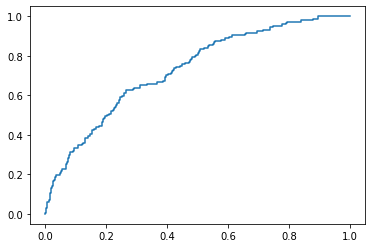

In [126]:
tpr, fpr, _ = roc_curve(y_test, prob[:,1])
plt.plot(tpr,fpr)
xgb.feature_importances_
x.columns
pd.Series(xgb.feature_importances_,x.columns).sort_values(ascending=False)

In [113]:
while True:
    ser = pd.Series(xgb.feature_importances_,x.columns).sort_values(ascending=False)
    if ser[ser==0].count() == 0:
        break
    col = list(ser[ser>0].index)
    col.append('mtag')
    x = climate_week[col].dropna().drop(['mtag'],axis=1)
    y = climate_week[col].dropna()['mtag']
    x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.2, stratify=y, random_state=111)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train, random_state=111)
    xgb = XGBClassifier()
    xgb.fit(x_train, y_train, eval_metric='auc', eval_set=[(x_train,y_train),(x_val,y_val)], early_stopping_rounds=10,verbose=0)
    pred = xgb.predict(x_test)
    prob = xgb.predict_proba(x_test)

    print('auc:',roc_auc_score(y_test, prob[:,1]))
    print(classification_report(y_test,pred))

auc: 0.795038535645472
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      1730
         1.0       0.25      0.01      0.01       144

    accuracy                           0.92      1874
   macro avg       0.59      0.50      0.49      1874
weighted avg       0.87      0.92      0.89      1874

auc: 0.7978042710340398
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96      1730
         1.0       0.70      0.05      0.09       144

    accuracy                           0.93      1874
   macro avg       0.81      0.52      0.53      1874
weighted avg       0.91      0.93      0.89      1874

auc: 0.7722262363519588
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      1730
         1.0       0.29      0.01      0.03       144

    accuracy                           0.92      1874
   macro avg       0.60      0.51      0.49      1874
wei

In [114]:
pd.Series(xgb.feature_importances_,x.columns).sort_values(ascending=False)

베이징해면기압6       0.009956
일 최심적설1        0.008761
150hPa_이슬점5    0.008583
100hPa_기온5     0.008423
400hPa_풍속0     0.007869
                 ...   
70hPa_풍속5      0.000279
300hPa_풍속1     0.000265
70hPa_기온2      0.000231
700hPa_풍속1     0.000219
100hPa_풍속5     0.000130
Length: 342, dtype: float32

In [ ]:
# 열 선택

In [129]:
climate_week.columns

Index(['평균 기온0', '최저 기온0', '최고 기온0', '1시간 최다강수량0', '일강수량0', '최대 순간풍속0',
       '최대 순간 풍속 풍향0', '최대 풍속0', '최대 풍속 풍향0', '평균 풍속0',
       ...
       '선양최고기온6', '선양최저기온6', '선양습도6', '선양풍향6', '선양풍속6', '선양강수량6', '선양해면기압6',
       '선양이슬점 온도6', 'target', 'mtag'],
      dtype='object', length=1178)

In [165]:
climate_week_filter = climate_week.filter(regex='습도|풍속|강수|기압')
climate_week_filter['target'] = spi['target']
climate_week_filter['mtag'] = spi['target'].shift(-30)

In [166]:
x = climate_week_filter.dropna().drop(['mtag','target'],axis=1)
y = climate_week_filter.dropna()['mtag']

In [167]:
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.2, stratify=y, random_state=111)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train, random_state=111)

In [160]:
# smote = SMOTE(random_state=11)
# x_train, y_train = smote.fit_resample(x_train,y_train)
# x_val, y_val = smote.fit_resample(x_train,y_train)

In [181]:
xgb = XGBClassifier( )
xgb.fit(x_train, y_train, eval_metric='auc', eval_set=[(x_train,y_train),(x_val,y_val)], early_stopping_rounds=10,verbose=2)
pred = xgb.predict(x_test)
prob = xgb.predict_proba(x_test)

print('auc:',roc_auc_score(y_test, prob[:,1]))
print(classification_report(y_test,pred))

[0]	validation_0-auc:0.65790	validation_1-auc:0.52697
[2]	validation_0-auc:0.77140	validation_1-auc:0.51505
[4]	validation_0-auc:0.88721	validation_1-auc:0.58794
[6]	validation_0-auc:0.93912	validation_1-auc:0.63050
[8]	validation_0-auc:0.96569	validation_1-auc:0.61380
[10]	validation_0-auc:0.97721	validation_1-auc:0.62452
[12]	validation_0-auc:0.98525	validation_1-auc:0.64561
[14]	validation_0-auc:0.98951	validation_1-auc:0.65442
[16]	validation_0-auc:0.99200	validation_1-auc:0.66540
[18]	validation_0-auc:0.99492	validation_1-auc:0.67257
[20]	validation_0-auc:0.99730	validation_1-auc:0.66243
[22]	validation_0-auc:0.99799	validation_1-auc:0.66317
[24]	validation_0-auc:0.99928	validation_1-auc:0.66925
[26]	validation_0-auc:0.99963	validation_1-auc:0.67603
[28]	validation_0-auc:0.99991	validation_1-auc:0.67680
[30]	validation_0-auc:0.99997	validation_1-auc:0.67257
[32]	validation_0-auc:0.99999	validation_1-auc:0.67344
[34]	validation_0-auc:1.00000	validation_1-auc:0.68353
[36]	validation

도쿄강수량5        0.005328
베이징강수량2       0.004344
삿포로해면기압1      0.004275
블라디보스톡강수량6    0.004275
후쿠오카강수량5      0.004262
                ...   
1시간 최다강수량4    0.000000
후쿠오카강수량0      0.000000
선양강수량3        0.000000
평양강수량3        0.000000
1시간 최다강수량0    0.000000
Length: 406, dtype: float32

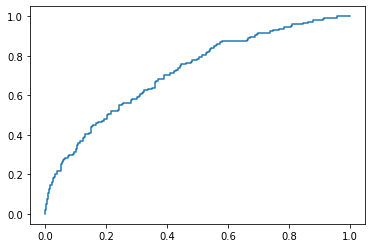

In [170]:
tpr, fpr, _ = roc_curve(y_test, prob[:,1])
plt.plot(tpr,fpr)
xgb.feature_importances_
x.columns
pd.Series(xgb.feature_importances_,x.columns).sort_values(ascending=False)

SVC()